#Sample Size Effect

Le but de ce notebook est d'etudier l'effet du sample size sur les performances des algorithmes implémentées (pour vérifier la préservation de la propriété de convergence rapide des Fuzzy Forest Crisp)

## Helper Code from Other notebook (for evaluating)

In [ ]:
!pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 3.9MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894088 sha256=117422641a26cccb0bdc29b6192128da2ebaca10aeadd57a2eb98f498314a940
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve, precision_recall_curve, auc, accuracy_score,f1_score,average_precision_score

import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import KFold

In [ ]:
def scores_preds(algorithm, X_train, X_test):
  # Randomly split X!
  t0 = time()
  algorithm.fit(X_train);
  tTrain = time() - t0;

  t0 = time();
  scores = algorithm.score_samples(X_test);
  tTest = time() - t0;

  preds = algorithm.predict(X_test)

  return (scores, preds, tTrain, tTest)

In [ ]:
def get_scores(label,scores,preds,y, tTrain = 0, tTest = 0):
  comparison_columns = ["Accuracy", "F1", "AUC ROC","AUC PR", "Train Time", "Testing Time"]
  comparaison_data = pd.DataFrame(columns=comparison_columns)

  comparaison_data.loc[label] = [accuracy_score(y,preds), f1_score(y,preds), roc_auc_score(y,scores),average_precision_score(y,scores, average='weighted'), tTrain, tTest]

  return comparaison_data

In [ ]:
def multi_tests(algorithm, X, y, repetition = 10, preds_negatif = False, scores_negatif = False):
  eval_columns = ["Accuracy", "F1", "AUC ROC","AUC PR", "Train Time", "Testing Time"]
  eval_data = pd.DataFrame(columns=eval_columns)

  for i in range(0,repetition):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    scores, preds, tTrain, tTest = scores_preds(iforest, X_train, X_test)

    if(preds_negatif):
      preds = preds == -1

    if(scores_negatif):
      scores = - scores

    eval_data.loc[f"test {i}"] = get_scores("sklearn - mulcross", scores,preds, y_test,tTrain, tTest).iloc[0]


  return eval_data

  

In [ ]:
def k_folds_tests(algorithm, X, y, folds = 10, preds_negatif = False, scores_negatif = False, force_numpy = False):

  eval_columns = ["Accuracy", "F1", "AUC ROC","AUC PR", "Train Time", "Testing Time"]
  eval_data = pd.DataFrame(columns=eval_columns)

  kf = KFold(n_splits= folds)

  i = 1

  for train_index, test_index in kf.split(X):

    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    if(force_numpy):
      X_train = X_train.to_numpy();
      X_test = X_test.to_numpy();

    scores, preds, tTrain, tTest = scores_preds(algorithm, X_train, X_test)

    if(preds_negatif):
      preds = preds == -1

    if(scores_negatif):
      scores = - scores

    eval_data.loc[f"test {i}"] = get_scores(" - ", scores,preds, y_test,tTrain, tTest).iloc[0]
    i+=1

  return eval_data

  

## The Experience

In [ ]:
iforest = IsolationForest()

mulcrossData = pd.read_csv("mulcross.csv")
mulcrossData.Target = mulcrossData.Target.map(lambda target: 0 if (target == "'Normal'" or target == 0) else 1)
mulcrossData["Class"] = mulcrossData.Target
mulcrossData = mulcrossData.drop(["Target"], axis = 1)

mulcrossX = mulcrossData.drop(["Class"], axis = 1)
mulcrossY = mulcrossData.Class

!! Veillez importer Fuzzifier.py et FuzzyIForest.py avant de procéder

In [ ]:
from Fuzzifier import Fuzzifier
from FuzzyIforest import AlphaCutIForestModel

In [ ]:
fuzz = Fuzzifier(mulcrossX)
fuzz.fuzzify()

In [ ]:
fuzzyX = fuzz.toDataFrame()

In [ ]:
fuzzyX.head()

,V1;poor,V1;average,V1;good,V2;poor,V2;average,V2;good,V3;poor,V3;average,V3;good,V4;poor,V4;average,V4;good
0,0.023579,0.976421,0.000000,0.0,0.954010,0.045990,0.000000,0.642930,0.357070,0.000000,0.851410,0.148590
1,0.146758,0.853242,0.000000,0.0,0.484340,0.515660,0.000000,0.759904,0.240096,0.000000,0.691427,0.308573
2,0.024912,0.975088,0.000000,0.0,0.780023,0.219977,0.099642,0.900358,0.000000,0.000000,0.984722,0.015278
3,0.000000,0.793485,0.206515,0.0,0.888924,0.111076,0.150643,0.849357,0.000000,0.020014,0.979986,0.000000
4,0.000000,0.878073,0.121927,0.0,0.682839,0.317161,0.072386,0.927614,0.000000,0.000000,0.840418,0.159582


In [ ]:
ifuzzyforest = AlphaCutIForestModel(number_of_trees = 100, sample_size = 256)

In [ ]:
tests = k_folds_tests(ifuzzyforest,fuzzyX, mulcrossY, folds = 4, force_numpy = True)

In [ ]:
tests.mean()

Accuracy         0.914902
F1               0.574468
AUC ROC          0.954171
AUC PR           0.513515
Train Time       1.083233
Testing Time    44.691475
dtype: float64

In [ ]:
df = pd.DataFrame({}, columns=['ROC','PR'])
for i in range(6,15):
  sample_size = 2 ** i

  ifuzzyforest = AlphaCutIForestModel(number_of_trees = 100, sample_size = sample_size)
  tests = k_folds_tests(ifuzzyforest,fuzzyX, mulcrossY, folds = 4, force_numpy = True)
  print(f"GOT TO {i}")
  df.loc[i,"ROC"] = tests.mean()["AUC ROC"]
  df.loc[i,"PR"] = tests.mean()["AUC PR"]

GOT TO 6
GOT TO 7
GOT TO 8
GOT TO 9
GOT TO 10
GOT TO 11
GOT TO 12
GOT TO 13
GOT TO 14


In [ ]:
df = pd.DataFrame({}, columns=['ROC','PR'])
for i in range(15,17):
  sample_size = 2 ** i

  ifuzzyforest = AlphaCutIForestModel(number_of_trees = 100, sample_size = sample_size)
  tests = k_folds_tests(ifuzzyforest,fuzzyX, mulcrossY, folds = 4, force_numpy = True)
  print(f"GOT TO {i}")
  df.loc[i,"ROC"] = tests.mean()["AUC ROC"]
  df.loc[i,"PR"] = tests.mean()["AUC PR"]

GOT TO 15


In [ ]:
df

,ROC,PR
6,0.990507,0.816703
7,0.963405,0.551428
8,0.945631,0.472417
9,0.923415,0.386929
10,0.886919,0.311377
11,0.899366,0.332899
12,0.878573,0.299002
13,0.858408,0.267558
14,0.832845,0.237795


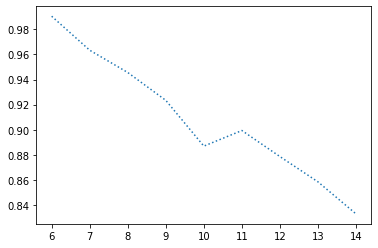

In [ ]:
plt.plot(df['ROC'], linestyle = 'dotted')